# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
%%javascript

// remove vertical scroll bars from long output cells

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re
# from IPython import display
# from IPython.core.display import HTML
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

#%matplotlib notebook
%matplotlib inline

plt.rcParams['figure.dpi'] = 100



C:\Users\lajos\AppData\Local\Temp\ipykernel_16608\745464124.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# A quick look at the data

In [4]:
def display_dataframe_info(df, df_name):
    display(HTML('<hr>'))
    display(HTML(f'<h2 style="text-align: center;">{df_name} DataFrame info</h2>'))
    # print(f'---- {df_name} ----')
    print(f'number of rows: {df.shape[0]}')
    print(f'number of cols: {df.shape[1]}')

    display(df.head())

    print('columns:')
    for col in df.columns:
        data_type = df[col].dtype
        num_nan = df[col].isna().sum()
        if num_nan:
            print(f'  {col} ({data_type}, NaN:{num_nan})')
        else:
            print(f'  {col} ({data_type})')
        if data_type==object:
            # print list of values and number of occurance of each value for categorical columns
            try:  # some columns might have unhashable values, for example lists
                values = list(df.groupby(col).groups.keys())
                if len(values)>9:  # if there are too many unique values, skip
                    continue
                print(f'    values:{values}')
                for i,v in df.groupby(col).count().max(axis=1).iteritems():
                    print(f'      {i}: {v}')
            except:
                pass

    display(df.describe())



display_dataframe_info(portfolio, 'portfolio')
display_dataframe_info(profile, 'profile')
display_dataframe_info(transcript, 'transcript')


number of rows: 10
number of cols: 6


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


columns:
  reward (int64)
  channels (object)
  difficulty (int64)
  duration (int64)
  offer_type (object)
    values:['bogo', 'discount', 'informational']
      bogo: 4
      discount: 4
      informational: 2
  id (object)


,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


number of rows: 17000
number of cols: 5


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


columns:
  gender (object, NaN:2175)
    values:['F', 'M', 'O']
      F: 6129
      M: 8484
      O: 212
  age (int64)
  id (object)
  became_member_on (int64)
  income (float64, NaN:2175)


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


number of rows: 306534
number of cols: 4


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


columns:
  person (object)
  event (object)
    values:['offer completed', 'offer received', 'offer viewed', 'transaction']
      offer completed: 33579
      offer received: 76277
      offer viewed: 57725
      transaction: 138953
  value (object)
  time (int64)


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Data Cleanup and Preparation

The `profile` dataframe has two columns with **NaN** values: **gender** and **income**. The number of **NaN** values are identical in the two columns, suggesting that both columns might have **NaN** values for the same rows only.

In [5]:
profile_isna = profile.isna().astype(int)
sum_gender_income_isna = profile_isna.gender + profile_isna.income
sum_gender_income_isna.unique()

array([2, 0])

It looks like either **gender** and **income** both have valid values, or they are both **NaN**. In addition, when **gender** and **income** values are missing, **age** is set to 118.

In [6]:
profile[profile['gender'].isna()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


We are trying to target offers based on demographic information, so we can remove profiles from the data set with **NaN** values.

In [7]:
print(f'profile number of rows: {profile.shape[0]}')

profile = profile.dropna()

print(f'profile number of rows after dropping NaNs: {profile.shape[0]}')

profile number of rows: 17000
profile number of rows after dropping NaNs: 14825


The transcript records contain a **time** field in hours. The promotion durations in the profile data set us days as units. We'll convert the timestamps in the transcript records to days to make sure that the same units are used.

In [8]:
# convert transcript time from hours to days, to match portfolio offer duration units
#
transcript.time /= 24

Convert date integers to days from the first registration date in the **profiles** data set.

In [9]:
def convert_date_to_day(x):
    """Convert a date integer from profile record to hours days from the first registration (20130729).
    Input:
      x: date integer (eg. 20171003)

    Output:
      days: days elapsed from 2013/07/29
    """
    x_str = str(x)
    from_date = datetime.date(2013, 7, 29)
    x_date = datetime.date(int(x_str[0:4]), int(x_str[4:6]), int(x_str[6:]))
    delta = x_date - from_date
    return delta.days

# convert date integers to days
#
profile['membership_start_day'] = profile['became_member_on'].apply(convert_date_to_day)


In [10]:
def create_dummy_columns(df, column_name, drop_column=False, prefix=None, prefix_sep='_'):
    """A helper function for creating dummy columns for category values.
    
    Inputs:
      df: a DataFrame
      column_name: the name of the category value column
      drop_column: whether to drop the original category column after creating the dummies
      prefix: if specified, will be used as dummy column prefix (otherwise use column_name)
      prefix_sep: separator to use after prefix

    Returns:
      df: DataFrame with dummy columns created
    """
    if prefix is None:
        prefix = column_name
    print(f'creating dummies for category column: {column_name}')
    # df_category_columns = pd.concat([df_category_columns, df[i]])
    # df_category_columns[i] = df[i]
    df = pd.concat([df if drop_column==False else df.drop(column_name, axis=1), 
                   pd.get_dummies(df[column_name], prefix=prefix, prefix_sep=prefix_sep)], 
                   axis=1)   
    return df 



Create age and income bins for each user in the profiles data set, and dummy columns for each binned value.

In [11]:
# create age bins
#
profile['bins_age']=pd.cut(x=profile.age, 
                            bins=[10,20,30,40,50,60,70,80,90,100,110], 
                            labels=['_10s','_20s','_30s','_40s','_50s','_60s','_70s','_80s','_90s','100s'])

print(profile.bins_age.value_counts().sort_index())

# create income bins
#
profile['bins_income']=pd.cut(x=profile.income, 
                                bins=[25000,50000,75000,100000,125000], 
                                labels=['25k+','50k+','75k+','100k+'])

display(profile.bins_income.value_counts().sort_index())

# create dummy columns for income and age categories
#
profile = create_dummy_columns(profile, 'bins_income', prefix='income')
profile = create_dummy_columns(profile, 'bins_age', prefix='age')
profile = create_dummy_columns(profile, 'gender')

# rename id -> person_id to match the offers DataFrame
#
profile.rename(columns={'id':'person_id'}, inplace=True)

display(profile.head())

_10s     340
_20s    1365
_30s    1597
_40s    2391
_50s    3590
_60s    2910
_70s    1646
_80s     767
_90s     214
100s       5
Name: bins_age, dtype: int64


25k+     4034
50k+     6436
75k+     3349
100k+    1006
Name: bins_income, dtype: int64

creating dummies for category column: bins_income
creating dummies for category column: bins_age
creating dummies for category column: gender


,gender,age,person_id,became_member_on,income,membership_start_day,bins_age,bins_income,income_25k+,income_50k+,...,age__40s,age__50s,age__60s,age__70s,age__80s,age__90s,age_100s,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1447,_50s,100k+,0,0,...,0,1,0,0,0,0,0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1380,_70s,75k+,0,0,...,0,0,0,1,0,0,0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1732,_60s,50k+,0,1,...,0,0,1,0,0,0,0,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1656,_60s,50k+,0,1,...,0,0,1,0,0,0,0,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1566,_50s,50k+,0,1,...,0,1,0,0,0,0,0,0,1,0


Create dummy columns for the **offer_type** column and the values in the **channels** column of the portfolio data set.

In [12]:
# make dummies for offer types
# 
portfolio = create_dummy_columns(portfolio, 'offer_type')
                            
# make dummies for channels
#
# portfolio = pd.concat([portfolio,
#                         pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0).add_prefix('channel_')],
#                         axis=1)
portfolio = pd.concat([portfolio,
                        pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum().add_prefix('channel_')],
                        axis=1)
# rename id -> offer_id to match the offers DataFrame
#
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

display(portfolio.head())

creating dummies for category column: offer_type


,reward,channels,difficulty,duration,offer_type,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


### Parsing Offer Records

Currently transactions, information about promotions and demographic info about customers are in separate tables.

We need to combine all these tables and find purchase transactions that were influenced by promotions.

Unfortunately transactions don't indicate whether purchases are tied to a specific promotion, so we'll have to assume that after a customer receives and views a promotion, the purchases belong to that offer until the offer completes or expires.

We'll use the code below to parse all offers. For each offer, we'll record:
- **person_id** - id of the person who received the offer
- **offer_id** - id of the offer matching the portfolio dataset
- **start_date** - date of offer received, in days after estart of experiment
- **end_date** - date offer expires, in days after estart of experiment
- **viewed** - whether the offer was viewed
- **completed** - wheteher the offer was completed
- **transaction_count** - number of sales tied to this offer
- **transaction_total** - purchase total


In [13]:
class OfferRecord:
    """This class is used to store information about an offer given to a customer."""
    def __init__(self, person_id, offer_id, date, duration):
        """Initializes an OfferRecord instance.
        Inputs: 
          person_id: id of customer
          offer_id: id of offer
          date: date offer is received (in days)
          duration: how long this offer is valid for (in days)
        """
        self.person_id = person_id
        self.offer_id = offer_id
        self.start_date = date
        self.end_date = self.start_date + duration
        self.viewed = 0
        self.completed = 0
        self.transaction_count = 0
        self.transaction_total = 0

    def as_dict(self):
        """Returns an OfferRecord as a python dict.
        Returns:
          dict: a python dictionary with the offer's properties
        """
        d = {}
        d['person_id'] = self.person_id
        d['offer_id'] = self.offer_id
        d['offer_viewed'] = self.viewed
        d['offer_completed'] = self.completed
        d['offer_start_date'] = self.start_date
        d['offer_end_date'] = self.end_date
        d['transaction_count'] = self.transaction_count
        d['transaction_total'] = self.transaction_total
        return(d)

    def __str__(self):
        """Returns a python string representation of the class, usually used to print the object."""
        return(f'{self.person_id} {self.offer_id} {self.start_date} {self.end_date} {self.viewed} {self.completed} {self.transaction_count} {self.transaction_total}')

def parse_offer_records(customer_transcript, portfolio):
    """
    Parses transcript records for offers a customer received and used.

    Inputs:
      customer_transcript: DataFrame containing all transcript records for a customer id, in chronological order
      portfolio: the portfolio DataFrame (used to get info about offers)

    Returns:
      offer_records: a list of offers records for the customer id
    """
    offer_record = None
    offer_records = []
    for i in range(len(customer_transcript)):
        r = customer_transcript.iloc[i]
        if r.event == 'offer received':
            if offer_record is not None:
                offer_records.append(offer_record)
            offer_id = r.value['offer id']
            offer_duration = portfolio.loc[portfolio.offer_id==offer_id].duration.item()
            offer_record = OfferRecord(r.person, offer_id, r.time, offer_duration)
        elif r.event == 'offer viewed':
            if r.value['offer id'] != offer_record.offer_id:
                print(f'offer id mismatch (viewed): person:{offer_record.person_id} {offer_record.offer_id} {r.value["offer id"]}')
            offer_record.viewed = 1
        elif r.event == 'offer completed':
            if offer_record.viewed and r.value['offer_id'] == offer_record.offer_id:
                offer_record.completed = 1
        elif r.event == 'transaction':
            if offer_record and offer_record.viewed and r.time<=offer_record.end_date:
                offer_record.transaction_count += 1
                offer_record.transaction_total += r.value['amount']
        
    if offer_record is not None:
        offer_records.append(offer_record)
            
    return offer_records



In [14]:
if not os.path.exists('data/offers.pkl'):
    offer_records = []

    for i in tqdm(range(len(profile))):
    # for i in tqdm(range(100)):
        customer = profile.iloc[i]
        customer_id = customer.person_id

        customer_transcript = transcript.loc[transcript.person==customer_id]

        for o in parse_offer_records(customer_transcript, portfolio):
            offer_records.append(o.as_dict())

    # print(offer_records)

    # for o in offer_records:
    #     print(o)

    print(f'number of offer records parsed: {len(offer_records)}')

    offers = pd.DataFrame.from_records(offer_records)

    print('pickle offers data')
    offers.to_pickle('data/offers.pkl')

print('unpickle offers data')
offers = pd.read_pickle('data/offers.pkl')

  0%|          | 0/14825 [00:00<?, ?it/s]

number of offer records parsed: 66501
pickle offers data
unpickle offers data


Merge the **portfolio** and **profile** records into the **offers** data set.

In [15]:
offers = pd.merge(offers, profile, on='person_id')
offers = pd.merge(offers, portfolio, on='offer_id')

print(f'offers shape: {offers.shape}')
display(offers.head())

offers shape: (66501, 44)


,person_id,offer_id,offer_viewed,offer_completed,offer_start_date,offer_end_date,transaction_count,transaction_total,gender,age,...,difficulty,duration,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,17.0,24.0,0,0.00,F,55,...,5,7,bogo,1,0,0,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0.0,7.0,2,37.67,F,75,...,5,7,bogo,1,0,0,1,1,0,1
2,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,17.0,24.0,0,0.00,M,68,...,5,7,bogo,1,0,0,1,1,0,1
3,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,7.0,14.0,0,0.00,M,65,...,5,7,bogo,1,0,0,1,1,0,1
4,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,17.0,24.0,1,15.63,M,65,...,5,7,bogo,1,0,0,1,1,0,1


Create lists for offer and bin column names for easy filtering.

In [16]:

age_column_names = [s for s in list(offers.columns) if re.compile('^age_').match(s)]
income_column_names = [s for s in list(offers.columns) if re.compile('^income_').match(s)]
gender_column_names = [s for s in list(offers.columns) if re.compile('^gender_').match(s)]
# income_column_names = []

offer_column_names = ['offer_viewed', 'offer_completed', 'offer_type', 'transaction_count', 'transaction_total']

# offers_by_age = offers[[]]

print(f'offer column names: {age_column_names}')
print(f'offer column names: {income_column_names}')
print(f'offer column names: {gender_column_names}')
print(f'offer column names: {offer_column_names}')

offer column names: ['age__10s', 'age__20s', 'age__30s', 'age__40s', 'age__50s', 'age__60s', 'age__70s', 'age__80s', 'age__90s', 'age_100s']
offer column names: ['income_25k+', 'income_50k+', 'income_75k+', 'income_100k+']
offer column names: ['gender_F', 'gender_M', 'gender_O']
offer column names: ['offer_viewed', 'offer_completed', 'offer_type', 'transaction_count', 'transaction_total']


(66501, 15)

(16641, 15)

(49860, 15)

(19577, 15)

,sent,viewed,completed,sent %,viewed %,completed %
10s,1508,1062,300,100,70.424403,19.893899
20s,6180,4263,1347,100,68.980583,21.796117
30s,7202,5286,1970,100,73.396279,27.353513
40s,10626,8344,3310,100,78.524374,31.150009
50s,16177,12197,4983,100,75.397169,30.802992
60s,13062,9865,4031,100,75.524422,30.860511
70s,7332,5514,2263,100,75.204583,30.864703
80s,3415,2590,1064,100,75.841874,31.156662
90s,976,723,301,100,74.077869,30.840164
100s,23,16,8,100,69.565217,34.782609


<AxesSubplot:title={'center':'Offers by Age'}>

<AxesSubplot:title={'center':'Offers by Age'}>

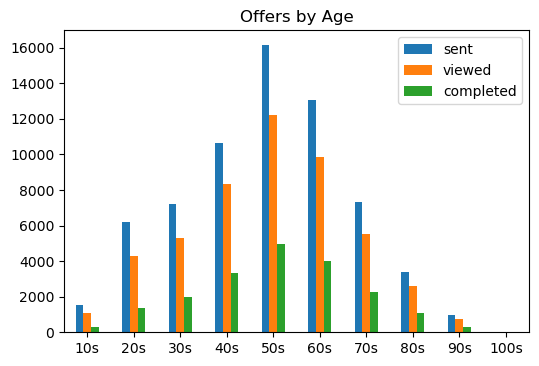

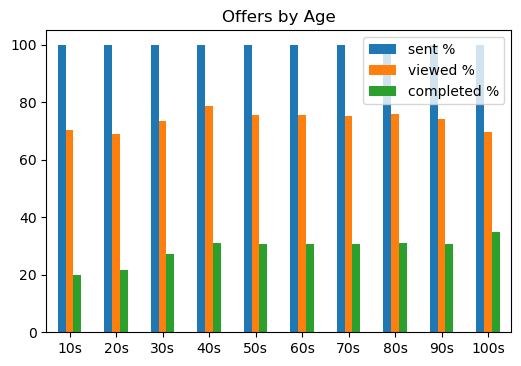

In [35]:
def rename_binned_index_names(df):
    new_index_names = {}
    for i in list(df.index):
        new_index_names[i] = i.split('_')[-1]
    df.rename(index=new_index_names, inplace=True)
    return df

display(offers[offer_column_names + age_column_names].shape)
display(offers.loc[offers.offer_viewed==False][offer_column_names + age_column_names].shape)
display(offers.loc[offers.offer_viewed==True][offer_column_names + age_column_names].shape)
display(offers.loc[offers.offer_completed==True][offer_column_names + age_column_names].shape)

offer_count_by_age = pd.DataFrame()

offer_count_by_age['sent'] = offers[age_column_names].sum()
offer_count_by_age['viewed'] = offers.loc[offers.offer_viewed==1][age_column_names].sum()
offer_count_by_age['completed'] = offers.loc[offers.offer_completed==1][age_column_names].sum()

offer_count_by_age['sent %'] = 100
offer_count_by_age['viewed %'] = offer_count_by_age['viewed'] / offer_count_by_age['sent'] * 100
offer_count_by_age['completed %'] = offer_count_by_age['completed'] / offer_count_by_age['sent'] * 100

offer_count_by_age = rename_binned_index_names(offer_count_by_age)

# display(list(offer_count_by_age.index))
# offer_count_by_age.index.rename('index', inplace=True)
display(offer_count_by_age)

display(offer_count_by_age[['sent', 'viewed', 'completed']].plot.bar(title='Offers by Age', rot=0))

display(offer_count_by_age[['sent %', 'viewed %', 'completed %']].plot.bar(title='Offers by Age', rot=0))
